Files already downloaded and verified
1
0.13660559908021241
0.5
0.005862902966327965
1
0.9930506022647023
0.5
0.9931398900225759
0.25
0.9931398900225759
0.125
0.9931059153750539
0.0625
0.9856718452647328
0.03125
0.6263194950297475
0.015625
0.09448571968823671
1
0.8986000493168831
0.5
0.8986542895436287
0.25
0.8986542895436287
0.125
0.8986510708928108
0.0625
0.8980007246136665
0.03125
0.8616598919034004
0.015625
0.5705710127949715
0.0078125
0.23044473677873611
0.00390625
0.09137789160013199
1
0.8072153627872467
0.5
0.8072763979434967
0.25
0.8072763979434967
0.125
0.8072748482227325
0.0625
0.8069515526294708
0.03125
0.7881156504154205
0.015625
0.6168035566806793
0.0078125
0.3158929646015167
0.00390625
0.14112311601638794
0.001953125
0.06376343965530396
1
0.7434445321559906
0.5
0.7435129582881927
0.25
0.7435129582881927
0.125
0.7435111701488495
0.0625
0.7432405054569244
0.03125
0.7294515669345856
0.015625
0.5998151004314423
0.0078125
0.34154412150382996
0.00390625
0.1639995276927948
0.001

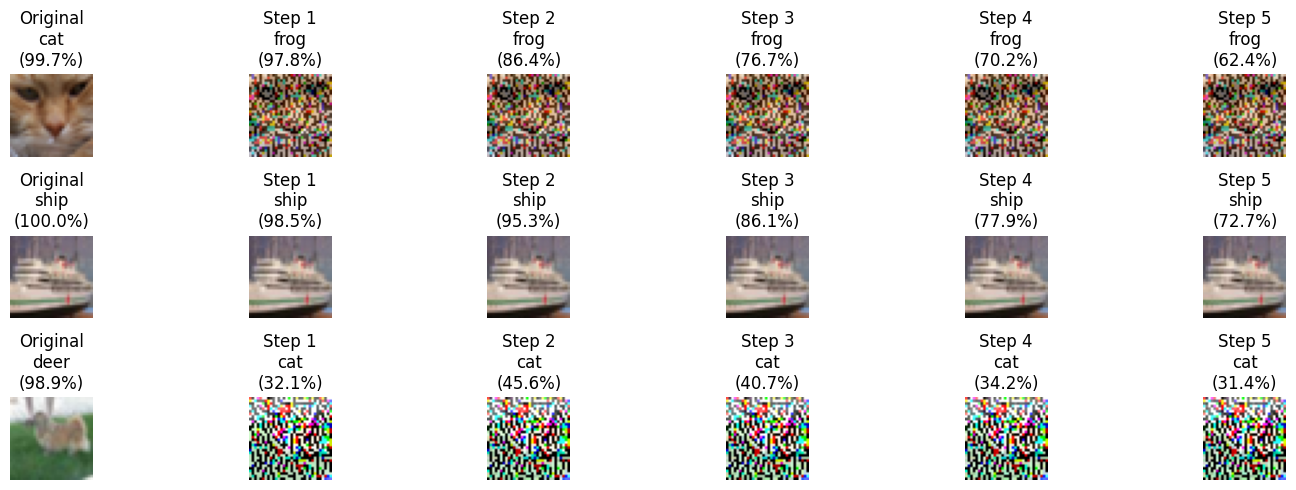

In [17]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Device Setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Define Transforms and Denormalization Function
# -------------------------------
# Using normalization with mean=0.5 and std=0.5 so that pixel values fall in [-1, 1].
norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    norm
])

def denormalize(img_tensor):
    """Convert a normalized tensor back to [0,1] for visualization."""
    return img_tensor * 0.5 + 0.5

# -------------------------------
# Load CIFAR-10 Dataset
# -------------------------------
cifar_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=eval_transform
)

# -------------------------------
# Define and Load Teacher Model
# -------------------------------
# Modified ResNet18 for CIFAR-10.
teacher = torchvision.models.resnet18(weights=None)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher.maxpool = nn.Identity()
num_ftrs = teacher.fc.in_features
teacher.fc = nn.Linear(num_ftrs, 10)

# Specify the path to the pre-trained teacher checkpoint.
teacher_checkpoint = "/notebooks/Resnet18/models/cifar10_best_model"

if os.path.exists(teacher_checkpoint):
    teacher_state = torch.load(teacher_checkpoint, map_location=device)
    teacher.load_state_dict(teacher_state)
else:
    print("Warning: Teacher checkpoint not found. Using an untrained teacher model.")

teacher.to(device)
teacher.eval()  # Freeze teacher during adversarial example generation

# -------------------------------
# Helper Function: Teacher Prediction
# -------------------------------
def get_teacher_prediction(image):
    """
    Runs the teacher model on a single image and returns the predicted label index and its confidence.
    
    Args:
        image (torch.Tensor): A normalized image tensor.
        
    Returns:
        pred (int): Predicted label index.
        conf (float): Softmax confidence.
    """
    image = image.to(device)
    with torch.no_grad():
        logits = teacher(image.unsqueeze(0))  # Add batch dimension
        probs = torch.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
    return pred.item(), conf.item()

# -------------------------------
# Adaptive Adversarial Trajectory Generation Function
# -------------------------------
def generate_adversarial_trajectory(image, teacher, num_steps=5, default_step_size=0.01, max_prob_increase=0.05):
    """
    Generate a trajectory of adversarial images ensuring that the increase in the teacher's softmax 
    probability for a fixed target class does not exceed a defined threshold per step.
    
    The target class is determined as the class corresponding to the second highest logit from the 
    initial image, and all gradient updates are computed toward increasing the probability of that fixed target.
    
    Args:
        image (torch.Tensor): Original image tensor of shape [C, H, W].
        teacher (torch.nn.Module): The teacher network.
        num_steps (int): Number of iterative updates (i.e. adversarial images to generate).
        default_step_size (float): The initial gradient update step size.
        max_prob_increase (float): Maximum allowed increase in the teacher's softmax probability for 
                                   the target class between steps.
    
    Returns:
        List[torch.Tensor]: A list of adversarial images forming the trajectory.
    """
    # Start with a copy of the image.
    x_adv = image.clone().detach().to(device)
    x_adv.requires_grad = True
    adversarial_images = []

    # Determine the fixed target class (second highest logit) from the initial image.
    with torch.no_grad():
        logits_init = teacher(x_adv.unsqueeze(0))
        sorted_logits_init, sorted_indices_init = torch.sort(logits_init, descending=True)
        target_class = sorted_indices_init[0, 1].item()

    # Generate adversarial trajectory.
    for step in range(num_steps):
        # --- Record the current softmax probability for the target class ---
        with torch.no_grad():
            logits_prev = teacher(x_adv.unsqueeze(0))
            softmax_prev = torch.softmax(logits_prev, dim=1)
            prev_target_prob = softmax_prev[0, target_class]

        # --- Compute the gradient update using the fixed target class ---
        logits = teacher(x_adv.unsqueeze(0))
        loss = -logits[0, target_class]  # Optimize to increase the target class logit (and thus probability).
        teacher.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.zero_()
        loss.backward()

        grad_sign = x_adv.grad.sign()

        # --- Adaptive step-size control: limit the increase in softmax probability ---
        current_step_size = default_step_size
        candidate_found = False
        candidate = None
        while not candidate_found:
            print(current_step_size)
            candidate = x_adv - current_step_size * grad_sign
            with torch.no_grad():
                logits_candidate = teacher(candidate.unsqueeze(0))
                softmax_candidate = torch.softmax(logits_candidate, dim=1)
                candidate_target_prob = softmax_candidate[0, target_class]
            prob_increase = candidate_target_prob.item() - prev_target_prob.item()
            if prob_increase > max_prob_increase:
                current_step_size = current_step_size / 2.0
            else:
                candidate_found = True
            print(prob_increase)

        # Accept candidate update.
        x_adv = candidate.clone().detach()
        x_adv.requires_grad = True
        adversarial_images.append(x_adv)

    return adversarial_images

# -------------------------------
# Expose Hyperparameters for the Attack
# -------------------------------
num_attack_steps = 5         # Number of gradient steps.
default_attack_step_size = 1  # Default step size for gradient update.
max_prob_increase_threshold = .10   # Maximum allowed drop in top logit between steps.

# -------------------------------
# Generate Adversarial Trajectories for Some Samples
# -------------------------------
# Randomly select a few examples for demonstration.
num_samples_to_show = 3
sample_indices = np.random.choice(len(cifar_dataset), num_samples_to_show, replace=False)

original_images = []
trajectories = []  # Each element is a list of adversarial images (one trajectory per sample)
sample_labels = []

for idx in sample_indices:
    img, label = cifar_dataset[idx]
    original_images.append(img)
    sample_labels.append(label)
    adv_traj = generate_adversarial_trajectory(
        img, teacher, num_steps=num_attack_steps,
        default_step_size=default_attack_step_size,
        max_prob_increase=max_prob_increase_threshold
    )
    trajectories.append(adv_traj)

# -------------------------------
# Visualization: Plot Images with Teacher Predictions & Confidence
# -------------------------------
# CIFAR-10 class names.
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(num_samples_to_show, num_attack_steps + 1, figsize=(15, 5))
for i in range(num_samples_to_show):
    # Visualize original image.
    orig_img = denormalize(original_images[i]).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
    pred, conf = get_teacher_prediction(original_images[i])
    teacher_info = f"{cifar_classes[pred]}\n({conf*100:.1f}%)"
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title("Original\n" + teacher_info)
    axes[i, 0].axis("off")
    
    # Visualize each adversarial step.
    for j in range(num_attack_steps):
        adv_img = denormalize(trajectories[i][j].detach()).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
        pred_adv, conf_adv = get_teacher_prediction(trajectories[i][j])
        teacher_info_adv = f"{cifar_classes[pred_adv]}\n({conf_adv*100:.1f}%)"
        axes[i, j+1].imshow(adv_img)
        axes[i, j+1].set_title(f"Step {j+1}\n" + teacher_info_adv)
        axes[i, j+1].axis("off")

plt.tight_layout()
plt.show()
